<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/13-linear_regression_without_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression without AutoGrad

In [12]:
!pip install --quiet torchviz

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchviz import make_dot # for computational graph
from IPython.display import display, Math, Latex # for display

In [14]:
for c in [torch, np]:
  print(c.__version__)

2.2.1+cu121
1.25.2


## Linear Regression
1. 데이터 정의 or 불러오기
2. linear 함수와 손실함수 선언하기
3. paramters 초기화하기
4. 미분 함수 정의하기
5. training loop 선언<br>
  : epoch만큼 순회하며
  - prediction하고 loss 계산
  - gradient 계산
  - update parameters
6. 결과 확인

## Linear Regression without pytorch

$$ y = w^Tx + b$$
- 엄밀히 affine transform (not linear transform)

## Farhenheit vs. Celcius
- from Fahrenheit(`x`) to Celcius (`y`) -> 선형변환

$$y = 1.8 \times x + 32$$

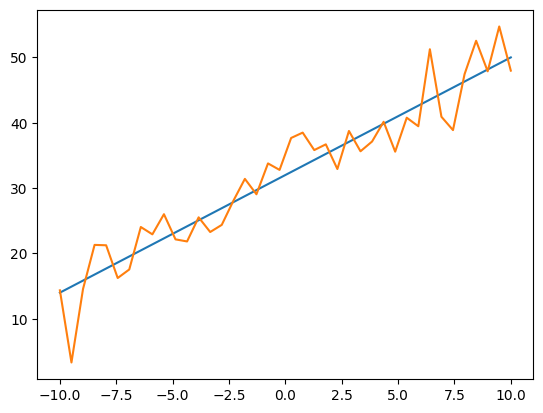

In [15]:
x = np.linspace(-10, 10, 40)
y_ideal = 1.8*x + 32.
y_noise = y_ideal + 4*np.random.randn((40)) # 노이즈 추가

plt.plot(x,y_ideal, x, y_noise)

In [16]:
y = torch.tensor(y_noise).float()
x = torch.tensor(x).float()

print(y.dtype, y.shape)
print(x.dtype, x.shape)

torch.float32 torch.Size([40])
torch.float32 torch.Size([40])


## Model and Loss

In [17]:
def ds_linear_model (x, w, b):
  ret_v = w * x + b
  return ret_v

In [18]:
def loss_func(pred, label):
  mse = ((pred - label)**2).mean()
  return mse

## Init model

In [19]:
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [20]:
pred = ds_linear_model(x, w, b)
pred

tensor([-10.0000,  -9.4872,  -8.9744,  -8.4615,  -7.9487,  -7.4359,  -6.9231,
         -6.4103,  -5.8974,  -5.3846,  -4.8718,  -4.3590,  -3.8462,  -3.3333,
         -2.8205,  -2.3077,  -1.7949,  -1.2821,  -0.7692,  -0.2564,   0.2564,
          0.7692,   1.2821,   1.7949,   2.3077,   2.8205,   3.3333,   3.8462,
          4.3590,   4.8718,   5.3846,   5.8974,   6.4103,   6.9231,   7.4359,
          7.9487,   8.4615,   8.9744,   9.4872,  10.0000])

In [21]:
print(loss_func(pred, pred))
print(loss_func(pred+1, pred))

tensor(0.)
tensor(1.)


## Gradient Descent
$$w_{t+1} = w_t - \eta\nabla_w L(w_t, X, Y)$$

$$\nabla_w L(w_t, X, Y) = \cfrac{\partial L(w_t, X, Y)}{\partial w}$$

$$\cfrac{f(x + Δx) - f(x - \Delta x)}{2x}$$에서

$$\nabla_w L(w_t, X, Y) \approx \cfrac{L(w_t + δ, X, Y) - L(w_t - \delta, X, Y)}{2\delta}$$

In [22]:
delta = 0.1
lr = 1e-3

d_loss_d_w = (loss_func(ds_linear_model(x, w+delta, b), y) - loss_func(ds_linear_model(x, w-delta, b), y)) / (2. * delta) # central difference (위 수식에서 아래)
tmp = d_loss_d_w.detach().numpy()
print(tmp)
display(Math(r'\cfrac{\partial L(w_t, X, Y)}{\partial w} \approx' + str(tmp)))

-59.06006


<IPython.core.display.Math object>

## Bias

$$b_{t+1} = b_t - \eta\nabla_b L(b_t, X, Y)$$

$$\nabla_b L(b_t, X, Y) = \cfrac{\partial L(b_t, X, Y)}{\partial b}$$

$$\nabla_b L(b_t, X, Y) \approx \cfrac{L(b_t + δ, X, Y) - L(b_t - \delta, X, Y)}{2\delta}$$

In [23]:
d_loss_d_b = (loss_func(ds_linear_model(x, b+delta, b), y) - loss_func(ds_linear_model(x, b-delta, b), y)) / (2. * delta) # central difference (위 수식에서 아래)
tmp = d_loss_d_b.detach().numpy()
print(tmp)
display(Math(r'\cfrac{\partial L(b_t, X, Y)}{\partial b} \approx' + str(tmp)))

-129.14612


<IPython.core.display.Math object>

## Update parameters

In [24]:
w = w - lr * d_loss_d_w
b = b - lr * d_loss_d_b

w, b

(tensor(1.0591), tensor(0.1291))

In [25]:
l = loss_func(pred+1, pred)
print(f'current loss: {l=}')
pred = ds_linear_model(x,w,b)
l_new = loss_func(pred, y)
print(f'new loss: {l_new=}')

current loss: l=tensor(1.)
new loss: l_new=tensor(1057.9080)


$L = MSE() = (pred - y)^2 = (f(x) - y)^2$<br>
$f = wx +b$

$\cfrac{\partial L}{\partial w} = \cfrac{\partial L}{\partial f}\cfrac{\partial f}{\partial w}$

In [26]:
# Loss를 f에 대해 편미분
def anal_d_loss_d_pred(pred, y):
  ret_v = 2. * (pred-y)
  return ret_v

# f를 w에 대해 편미분
def anal_d_pred_d_w(x, w, b):
  return x

# f를 b에 대해 편미분
def anal_d_pred_d_b(w, x, b):
  return 1.

$$\nabla L = \begin{bmatrix} \cfrac{dL}{dw} \\ \cfrac{dL}{db} \end{bmatrix}$$



In [27]:
def get_grad(x, y, pred, w, b):
  v_d_loss_d_pred = anal_d_loss_d_pred(pred, y)
  v_d_loss_d_w = v_d_loss_d_pred * anal_d_pred_d_w(x, w, b)
  v_d_loss_d_b = v_d_loss_d_pred * anal_d_pred_d_b(x, w, b)

  return torch.stack([v_d_loss_d_w.mean(), v_d_loss_d_b.mean()])

In [28]:
w_init = 1.
b_init = 0.

preds = ds_linear_model(x, w_init, b_init)
l = loss_func(preds, y)
grad = get_grad(x, y, preds, w, b)

display(f'{grad=}')

'grad=tensor([-59.0606, -64.2216])'

# Training

In [29]:
def ds_training(x, y, model, _w, _b, n_epoch, lr, log_flag = False):
  w, b = _w, _b
  for epoch in range(n_epoch):

    pred = model(x,w,b)
    l = loss_func(pred, y)

    if torch.isinf(l).any():
      print('Error: loss is infinity.')
      print(f'{epoch=}')
      break

    # update parameters
    grad = get_grad(x, y, pred, w, b)
    w = w - lr* grad[0]
    b = b - lr* grad[1]

    if epoch in [0, 1, 2, 3, 4, 5, 100, 1000, 2000, 3000, 4000, 5000]:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')
      if log_flag:
        print(f'{w=}, {b=}')
    elif epoch in [6, 101, 1001, 2001, 3001, 4001, 5001]:
      print('---')

  return w, b

In [30]:
w_n, b_n = ds_training(x, y, ds_linear_model,
            torch.ones(()),
            torch.zeros(()),
            5000,
            1e-3
)
w_n, b_n

Epoch 0: Loss 1069.5511
Epoch 1: Loss 1062.0649
Epoch 2: Loss 1055.0505
Epoch 3: Loss 1048.4460
Epoch 4: Loss 1042.1984
Epoch 5: Loss 1036.2615
---
Epoch 100: Loss 704.4550
---
Epoch 1000: Loss 32.3720
---
Epoch 2000: Loss 13.9053
---
Epoch 3000: Loss 13.5684
---
Epoch 4000: Loss 13.5623
---


(tensor(1.8427), tensor(32.1093))

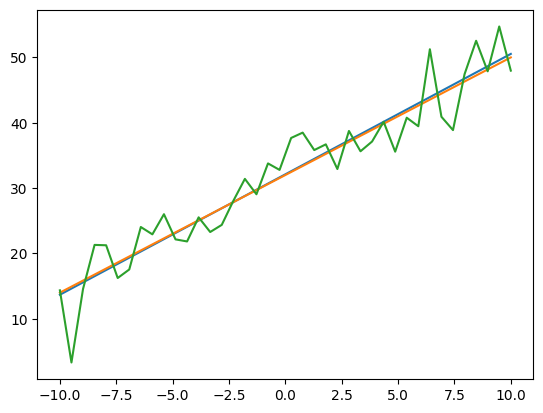

In [31]:
pred = ds_linear_model(x, w_n, b_n)

plt.plot(x, pred, x, y_ideal, x, y)